In [ ]:
!python3 --version

Python 3.11.11


# 1- Imports 📥

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization,RandomFlip, RandomRotation, RandomZoom
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import os
import pandas as pd

# 2 - Loading the dataset 📊

In [ ]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f"Original Train set: {x_train.shape}")
print(f"Original Test set: {x_test.shape}")
# Reserve 5000 samples from the training set for validation
x_train, x_dev = x_train[:45000], x_train[45000:]
y_train, y_dev = y_train[:45000], y_train[45000:]

print(f"Train set: {x_train.shape}")
print(f"Dev set: {x_dev.shape}")
print(f"Test set: {x_test.shape}")
# Define batch size
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE  # Optimizes performance
# Define batch size
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE  # Optimizes performance
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),  # Random horizontal flipping
    RandomRotation(0.1),       # Random rotation (10% of 360 degrees)
    RandomZoom(0.1)            # Random zoom
])

# Function to resize and normalize images
def preprocess(image, label, augment=False):
    image = tf.image.resize(image, (224, 224))  # Resize dynamically

    if augment:
        image = data_augmentation(image)  # Apply augmentations

    image = preprocess_input(image)  # Normalize for MobileNet
    return image, label

# Convert datasets to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dev_dataset = tf.data.Dataset.from_tensor_slices((x_dev, y_dev))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Apply preprocessing and batching
train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(buffer_size=10000)  # Shuffle data for randomness
    .map(lambda x, y: preprocess(x, y, augment=True), num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
dev_dataset = (
    dev_dataset
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_dataset = (
    test_dataset
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Print dataset structure
print(train_dataset)
print(dev_dataset)
print(test_dataset)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Original Train set: (50000, 32, 32, 3)
Original Test set: (10000, 32, 32, 3)
Train set: (45000, 32, 32, 3)
Dev set: (5000, 32, 32, 3)
Test set: (10000, 32, 32, 3)
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>


# 3- Loading the Original saved model (protobuff)

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Note: original attempt `from_saved_model()` failed, likely because TensorFlow could not properly trace the computation graph from the SavedModel format. Using concrete functions instead ensures that TensorFlow converts the exact computation graph that will be executed, avoiding issues with dynamic tracing.Instead of letting TFLiteConverter try to extract the function itself (which failed), we explicitly passed the extracted function.
The automatic graph tracing used by TFLiteConverter.from_saved_model() sometimes fails due to:

1. Unsupported Operations (not all TensorFlow ops are supported in TFLite)
2. Dynamic Shapes (TFLite prefers static input shapes)
3. Control Flow Complexity (if the model has loops or conditionals)

By extracting a concrete function, we are giving TFLite a static, fully-defined graph, making conversion more reliable.

In [ ]:
original_model_path = '/content/drive/MyDrive/saved_models/mobileNetAug_CIFAR10'

# Load the model
model = tf.saved_model.load(original_model_path)
concrete_func = model.signatures["serving_default"]  # Explicitly get the function

## Create the directory to store different versions of output models

In [ ]:
# check if mobileNet_cifar10_quantization directory doesn't exist create it
if not os.path.exists('/content/drive/My Drive/saved_models/mobileNet_cifar10_quantization'):
    os.makedirs('/content/drive/My Drive/saved_models/mobileNet_cifar10_quantization')
    print("Folder: mobileNet_cifar10_quantization created successfully")
else:
    print("Folder: mobileNet_cifar10_quantization already exists skipping folder creation...")

Folder: mobileNet_cifar10_quantization already exists skipping folder creation...


## Converting the Original model to tflite format

✅ This is done to ensure that the comparison between the original and quantized models is fair.

In [ ]:
# Convert using the concrete function
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
tflite_model = converter.convert()

# Save the TFLite model
tflite_original_model_path = "/content/drive/My Drive/saved_models/mobileNet_cifar10_quantization/mobilenet_cifar10_95.tflite"
with open(tflite_original_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {tflite_original_model_path}")

TFLite model saved at: /content/drive/My Drive/saved_models/mobileNet_cifar10_quantization/mobilenet_cifar10_95.tflite


# 4- Float16 Quantization
✅ What happens?

The model weights are converted from float32 to float16, reducing the model size by half. Computation still happens in float32 on most hardware unless the device supports float16 acceleration (e.g., some GPUs and TPUs).
Ensures that numerical precision loss is minimal.

In [ ]:
# Convert to TFLite format Dynamic Range Quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model_fp16 = converter.convert()
tflite_model_fp16_path = "/content/drive/My Drive/saved_models/mobileNet_cifar10_quantization/mobilenet_quantized_fp16_cifar10.tflite"
with open(tflite_model_fp16_path, "wb") as f:
    f.write(tflite_model_fp16)

print(f"Quantized Model Saved at: {tflite_model_fp16_path}")

Quantized Model Saved at: /content/drive/My Drive/saved_models/mobileNet_cifar10_quantization/mobilenet_quantized_fp16_cifar10.tflite


# 5- Dynamic Range Quantization
✅ What happens?

The model weights are quantized to INT8 or UINT8, but activations remain in float32 during inference.
The model is smaller and runs faster than float16 or full float32 models.
Since activations remain in float32, there is less precision loss compared to full INT8 quantization.

In [ ]:
# Convert to TFLite format Dynamic Range Quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Apply dynamic range quantization

# Convert the model
tflite_model_int8 = converter.convert()

# Save the converted model
tflite_model_int8_path = "/content/drive/My Drive/saved_models/mobileNet_cifar10_quantization/mobilenet_quantized_INT8_cifar10.tflite"
with open(tflite_model_int8_path, "wb") as f:
    f.write(tflite_model_int8)

print(f"Quantized Model Saved at: {tflite_model_int8_path}")

Quantized Model Saved at: /content/drive/My Drive/saved_models/mobileNet_cifar10_quantization/mobilenet_quantized_INT8_cifar10.tflite


# 6- Full INT8 Quantization (Weights and Activations)

In [ ]:
# Load the trained model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable optimization

# Define a representative dataset function (MANDATORY for int8 activations)
def representative_dataset():
    for batch_images, _ in test_dataset.take(10):  # Use enough samples
        for image in batch_images:
            yield [tf.expand_dims(tf.cast(image, tf.float32), axis=0).numpy()]  # Add batch dim
# Apply full quantization
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # Fully int8
converter.inference_input_type = tf.int8  # Ensure model inputs are int8
converter.inference_output_type = tf.int8  # Ensure model outputs are int8
# Convert and save the quantized model
tflite_model_full_int8 = converter.convert()

# Save the converted model
tflite_model_full_int8_path = "/content/drive/My Drive/saved_models/mobileNet_cifar10_quantization/mobilenet_quantized_FULL_INT8_cifar10.tflite"
with open(tflite_model_full_int8_path, "wb") as f:
    f.write(tflite_model_full_int8)
print(f"Quantized Model Saved at: {tflite_model_full_int8_path}")

Quantized Model Saved at: /content/drive/My Drive/saved_models/mobileNet_cifar10_quantization/mobilenet_quantized_FULL_INT8_cifar10.tflite


# 7- Comparing sizes of the Model ⚖️

In [ ]:
size_in_mb_original = os.path.getsize(tflite_original_model_path) / (1024 * 1024)
size_in_mb_float16 = os.path.getsize(tflite_model_fp16_path) / (1024 * 1024)
size_in_mb_INT8 = os.path.getsize(tflite_model_int8_path) / (1024 * 1024)
size_in_mb_full_INT8=os.path.getsize(tflite_model_full_int8_path) / (1024 * 1024)
print(f"Model Size before Quantization: {size_in_mb_original:.2f} MB")
print(f"Model Size after float16 Quantization: {size_in_mb_float16:.2f} MB")
print(f"Model Size after INT8 Quantization: {size_in_mb_INT8:.2f} MB")
print(f"Model Size after Full INT8 Quantization: {size_in_mb_full_INT8:.2f} MB")

Model Size before Quantization: 13.37 MB
Model Size after float16 Quantization: 6.71 MB
Model Size after INT8 Quantization: 3.53 MB
Model Size after Full INT8 Quantization: 3.66 MB


# 8- Comparing performances of the Model 📈🎯🚀

In [ ]:
tflite_original_model_path = "/content/drive/My Drive/saved_models/mobileNet_cifar10_quantization/mobilenet_cifar10_95.tflite"
tflite_model_fp16_path = "/content/drive/My Drive/saved_models/mobileNet_cifar10_quantization/mobilenet_quantized_fp16_cifar10.tflite"
tflite_model_int8_path = "/content/drive/My Drive/saved_models/mobileNet_cifar10_quantization/mobilenet_quantized_INT8_cifar10.tflite"
tflite_model_full_int8_path = "/content/drive/My Drive/saved_models/mobileNet_cifar10_quantization/mobilenet_quantized_FULL_INT8_cifar10.tflite"

In [ ]:
# Take only the first 1000 images from the test dataset
num_images = 1000
inference_testset = test_dataset.take(num_images // BATCH_SIZE)  # Take enough batches
# print the length of the inference testset
test_img_count = 0
for images, _ in inference_testset:
    test_img_count += images.shape[0]  # Add the batch size each time

print(f"Subset contains {test_img_count} images")

Subset contains 960 images


In [ ]:
# Function to run inference on TFLite model with CIFAR-10 dataset
def evaluate_tflite_model(interpreter, dataset):
    correct = 0
    total = 0

    # Get input and output tensor details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Get quantization scale and zero point for input and output tensors
    input_scale, input_zero_point = input_details[0]['quantization']
    output_scale, output_zero_point = output_details[0]['quantization']
    start_time = time.time()
    for images, labels in dataset:
        for i in range(len(images)):
            # Prepare input image
            input_data = np.expand_dims(images[i].numpy(), axis=0)

            # Ensure proper INT8 conversion if the model is quantized
            if input_details[0]['dtype'] == np.int8:
                input_data = ((input_data / input_scale) + input_zero_point).astype(np.int8)
            else:
                input_data = input_data.astype(np.float32)

            # Set the input tensor
            interpreter.set_tensor(input_details[0]['index'], input_data)

            # Run inference
            interpreter.invoke()

            # Get the output tensor
            output_data = interpreter.get_tensor(output_details[0]['index'])

            # If the model is quantized (INT8), dequantize output
            if output_details[0]['dtype'] == np.int8:
                output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale

            # Get the predicted class (highest probability)
            predicted_label = np.argmax(output_data, axis=1)[0]

            # Compare with ground truth
            if predicted_label == labels[i].numpy():
                correct += 1
            total += 1
    execution_time = time.time() - start_time
    accuracy = (correct / total) * 100
    return accuracy, execution_time


## 1- Original Model

In [ ]:
# Load the model
interpreter = tf.lite.Interpreter(model_path=tflite_original_model_path)
interpreter.allocate_tensors()
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
# Run evaluation on TFLite model
original_accuracy, original_execution_time = evaluate_tflite_model(interpreter, inference_testset)
print(f"TFLite Model Accuracy: {original_accuracy:.2f} %")
print(f"TFLite Inference Time for {test_img_count} images: {original_execution_time:.2f} s")

TFLite Model Accuracy: 93.85 %
TFLite Inference Time for 960 images: 40.96 s


## 2- Float16 Quantizatied model

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_fp16_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run evaluation on TFLite model
fp16_accuracy, fp16_execution_time = evaluate_tflite_model(interpreter, inference_testset)
print(f"TFLite (FP16 Quantized) Model Accuracy: {fp16_accuracy:.2f} %")
print(f"TFLite (FP16 Quantized) Inference Time for {test_img_count} images: {fp16_execution_time:.2f} s")

TFLite (FP16 Quantized) Model Accuracy: 93.85 %
TFLite (FP16 Quantized) Inference Time for 960 images: 28.62 s


## 3- Dynamic Range Quantizatied (INT8 weights)

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_int8_path)
interpreter.allocate_tensors()
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run evaluation on TFLite model
int8_accuracy, int8_execution_time = evaluate_tflite_model(interpreter, inference_testset)
print(f"TFLite (INT8 Quantized) Model Accuracy: {int8_accuracy:.2f} %")
print(f"TFLite (INT8 Quantized) Inference Time for {test_img_count} images: {int8_execution_time:.2f} s")

TFLite (INT8 Quantized) Model Accuracy: 92.40 %
TFLite (INT8 Quantized) Inference Time for 960 images: 40.96 s


In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_full_int8_path)
interpreter.allocate_tensors()
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
# Run evaluation on TFLite model
full_int8_accuracy, full_int8_execution_time = evaluate_tflite_model(interpreter, inference_testset)
print(f"TFLite (FULL INT8 Quantized) Model Accuracy: {full_int8_accuracy:.2f} %")
print(f"TFLite (FULL INT8 Quantized) Inference Time for {test_img_count} images: {full_int8_execution_time:.2f} s")

TFLite (FULL INT8 Quantized) Model Accuracy: 89.58 %
TFLite (FULL INT8 Quantized) Inference Time for 960 images: 29.81 s


# Results Summary 📝

In [ ]:
data = {
    'Model': ['Original Model', 'FP16 Quantized', 'INT8 Quantized','Full INT8 Quantized'],
    'Accuracy (%)': [original_accuracy, fp16_accuracy, int8_accuracy, full_int8_accuracy],
    f'Inference Time for {test_img_count} images (s):': [original_execution_time, fp16_execution_time, int8_execution_time, full_int8_execution_time],
    'Model Size (MB)': [size_in_mb_original, size_in_mb_float16, size_in_mb_INT8, size_in_mb_full_INT8],
}
results_table = pd.DataFrame(data)
results_table

,Model,Accuracy (%),Inference Time for 960 images (s):,Model Size (MB)
0,Original Model,93.854167,40.956949,13.374702
1,FP16 Quantized,93.854167,28.619762,6.705235
2,INT8 Quantized,92.395833,40.955777,3.528984
3,Full INT8 Quantized,89.583333,29.812876,3.656235


In [ ]:
# Define model names
models = ["Original Model", "FP16 Quantized", "INT8 Quantized", "Full INT8 Quantized"]
# Define metrics for different versions of the model
model_sizes = [size_in_mb_original, size_in_mb_float16, size_in_mb_INT8, size_in_mb_full_INT8]  # in MB
model_accuracy = [original_accuracy, fp16_accuracy, int8_accuracy, full_int8_accuracy]  # in %
inference_speed = [original_execution_time, fp16_execution_time, int8_execution_time, full_int8_execution_time]  # in ms
# Set width for bars
bar_width = 0.6
x = np.arange(len(models))
def plot_barchart(values, ylabel, title, colors, value_format="{}"):
    plt.figure(figsize=(10, 5))
    bars = plt.bar(x, values, width=bar_width, color=colors)

    # Add text inside the bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
                 value_format.format(value), ha='center', va='center', fontsize=12, color='white', fontweight='bold')

    plt.xticks(x, models)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

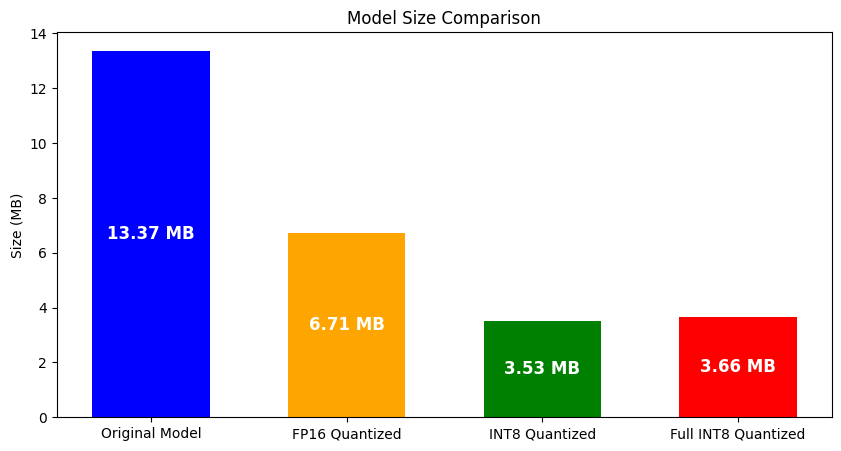

In [ ]:
# Plot Model Size
plot_barchart(model_sizes, "Size (MB)", "Model Size Comparison", ['blue', 'orange', 'green', 'red'], "{:.2f} MB")

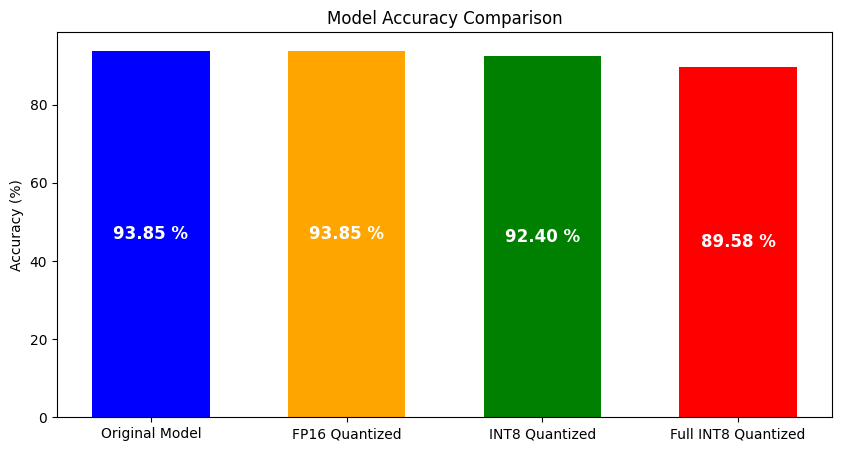

In [ ]:
# Plot Model Accuracy
plot_barchart(model_accuracy, "Accuracy (%)", "Model Accuracy Comparison", ['blue', 'orange', 'green', 'red'], "{:.2f} %")